In [19]:
import itertools

import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

from src.gaussian_noise import BetaSchedule, ModelMeanType, ModelVarType
from src.respace import SpacedDiffusion, space_timesteps
from src.rplan.dataset import RPlanImageDataset
from src.rplan.types import ImagePlan
from src.rplan_masks.karras.cfg import CFGUnet, CFGUnetWithScale
from src.utils.sampler import Sampler


In [24]:
T = 1000

device = torch.device(
    'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

diffusion = SpacedDiffusion(space_timesteps(T, 'ddim100'), T, BetaSchedule.COSINE, ModelMeanType.EPSILON, ModelVarType.FIXED_SMALL,
                              device=device)
model = CFGUnet(dim=64, channels=6, out_dim=3, cond_drop_prob=0, use_bubbles=True).to(device)

# model.load_state_dict(torch.load(
#     '/Users/mariodeaconescu/Library/CloudStorage/GoogleDrive-mariodeaconescu2003@gmail.com/My Drive/ColabFiles/diffusion_generation/export/checkpoints/2025-03-07_16-42-58/model_49.pt', map_location=device))
model_path = '/Users/mariodeaconescu/Library/CloudStorage/GoogleDrive-mariodeaconescu2003@gmail.com/My Drive/ColabFiles/diffusion_generation/export/checkpoints_unet_bubbles/2025-04-21_00-54-32/model_29_500.pt'
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
full_model = CFGUnetWithScale(model).to(device)
sampler = Sampler(full_model, (3, 64, 64), diffusion, ddim=True, device=device)

In [25]:
dataset = RPlanImageDataset(data_path='../data/rplan', mask_size=(64, 64), shuffle_rooms=True,
                                random_scale=0.6)

In [34]:
def show_samples(condition_scales: list[float], rescaled_phis: list[float], num_samples: int = 1):
    random_samples1 = [dataset[np.random.randint(0, len(dataset))] for _ in range(num_samples)]
    random_samples2 = [dataset[np.random.randint(0, len(dataset))] for _ in range(num_samples)]
    random_sample_batched1 = ImagePlan.collate(random_samples1)
    random_sample_batched2= ImagePlan.collate(random_samples2)
    _, _, _, room_types, bubbles, _ = random_sample_batched1
    _, _, _, _, _, masks = random_sample_batched2
    room_types = room_types.to(device)
    bubbles = bubbles.to(device)
    masks = masks.to(device)

    results = {}
    for condition_scale, rescaled_phi in tqdm(itertools.product(condition_scales, rescaled_phis)):
        samples = sampler.sample(
            num_samples,
            model_kwargs={
                'room_types': room_types,
                'bubbles': bubbles,
                'masks': masks,
                'condition_scale': condition_scale,
                'rescaled_phi': rescaled_phi,
            }
        ).cpu().numpy()
        results[(condition_scale, rescaled_phi)] = [ImagePlan(walls=walls, image=rooms, door_image=doors) for rooms, walls, doors in samples]

    fig, axs = plt.subplots(len(results) * 2 + 1, num_samples, figsize=(num_samples * 3, (len(results) + 1) * 3))
    for j in range(num_samples):
        axs[0, j].imshow(random_samples1[j].bubbles[0], vmin=-1, vmax=1)

    for i, ((condition_scale, rescaled_phi), samples) in tqdm(enumerate(results.items())):
        for j in range(num_samples):
            axs[2 * i + 1, j].imshow(samples[j].image, vmin=-1, vmax=1)
            axs[2 * i + 1, j].set_title(f'Sampled {condition_scale}, {rescaled_phi}')
            axs[2 * i + 2, j].imshow(samples[j].walls, vmin=-1, vmax=1)
            axs[2 * i + 2, j].set_title('Sampled Walls')
            # axs[i, j + 1].imshow(samples[j].door_image, vmin=-1, vmax=1)
            # axs[i, j + 1].set_title('Sampled Doors')
            # full = np.stack([samples[j].image, samples[j].walls, samples[j].door_image], axis=0)
            # full = (full + 1) / 2 * 255
            # full = full.astype(np.uint8)
            # axs[i, j + 1].imshow(full.transpose(1, 2, 0))
            # axs[i, j + 1].set_title('Full Sampled')

    plt.tight_layout()
    plt.show()

In [35]:
condition_scales = [0, 0.5, 1, 1.5, 2, 5, 10]
rescaled_phis = np.linspace(0, 1, 5).tolist()

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  5.47it/s]
4it [00:00, 14.84it/s]
7it [00:00, 18.90it/s]
10it [00:00, 21.18it/s]
13it [00:00, 22.81it/s]
16it [00:00, 24.18it/s]
19it [00:00, 25.41it/s]
22it [00:00, 26.16it/s]
25it [00:01, 26.29it/s]
28it [00:01, 25.85it/s]
31it [00:01, 25.08it/s]
34it [00:01, 25.52it/s]
37it [00:01, 25.59it/s]
40it [00:01, 25.87it/s]
43it [00:01, 26.13it/s]
46it [00:01, 26.76it/s]
49it [00:02, 26.79it/s]
52it [00:02, 27.10it/s]
55it [00:02, 26.86it/s]
58it [00:02, 27.45it/s]
61it [00:02, 27.43it/s]
64it [00:02, 27.27it/s]
67it [00:02, 27.40it/s]
70it [00:02, 27.89it/s]
73it [00:02, 26.75it/s]
76it [00:03, 27.04it/s]
80it [00:03, 27.85it/s]
83it [00:03, 27.97it/s]
86it [00:03, 27.95it/s]
89it [00:03, 27.79it/s]
92it [00:03, 28.28it/s]
95it [00:03, 27.94it/s]
100it [00:03, 25.84it/s][A
1it [00:03,  3.87s/it]
0it [00:00, ?it/s]
3it [00:00, 25.30it/s]
6it [00:00, 27.12it/s]
9it [00:00, 27.12it/s]
12it [00:00, 27.01it/s]
15it [00:00, 26.87it/s]
18it [00:00

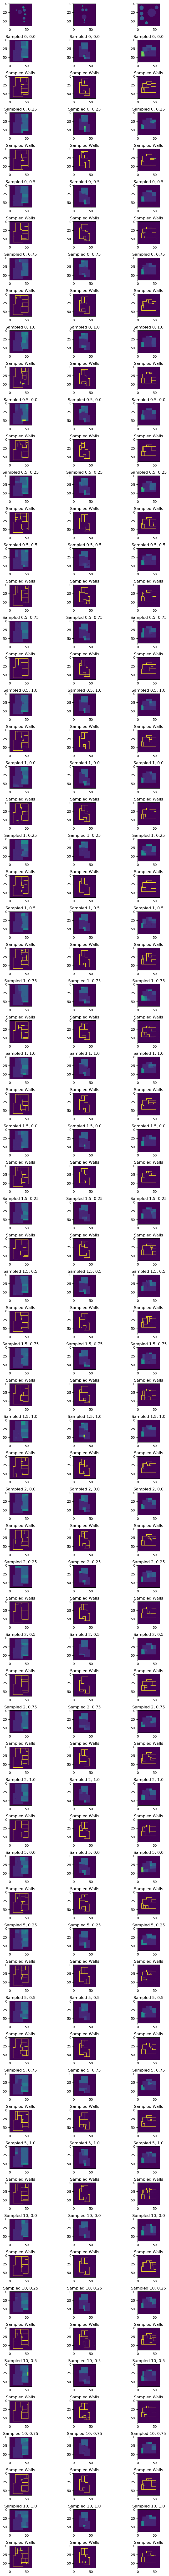

In [36]:
show_samples(condition_scales, rescaled_phis, num_samples=3)